In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Kisan Bandhu V2 — Regime Detection

**Objective**

Identify whether the market is behaving normally or abnormally using
deviations from the frozen V1 baseline.

This notebook:
- Uses only V1 outputs
- Does NOT retrain any price model
- Produces regime labels used downstream for explanation and advisory

Regime states:
- normal
- high_volatility
- shock


In [2]:
# Kisan Bandhu V1 output

v1 = pd.read_csv("v1_baseline_outputs.csv", parse_dates=["date"])
v1 = v1.sort_values("date").reset_index(drop=True)
v1.head()

,date,actual_price,expected_price,p10_price,p50_price,p90_price,residual,residual_z,rolling_vol,baseline_confidence,year
0,2018-04-28,1600.0,1675.360375,1265.104613,1675.360375,2085.616137,-75.360375,-0.235125,NaN,low,2018
1,2018-04-29,1650.0,1601.336964,1191.081202,1601.336964,2011.592726,48.663036,0.151829,NaN,low,2018
2,2018-04-30,1600.0,1638.869059,1228.613297,1638.869059,2049.124821,-38.869059,-0.121272,NaN,low,2018
3,2018-05-10,2000.0,1667.156916,1256.901153,1667.156916,2077.412678,332.843084,1.038472,NaN,low,2018
4,2018-05-11,1800.0,2028.614585,1618.358822,2028.614585,2438.870347,-228.614585,-0.713279,NaN,low,2018


In [3]:
v1.tail()

,date,actual_price,expected_price,p10_price,p50_price,p90_price,residual,residual_z,rolling_vol,baseline_confidence,year
2911,2025-12-15,2400.0,2228.385347,1002.456689,2228.385347,3454.314004,171.614653,0.179184,364.675021,normal,2025
2912,2025-12-17,2400.0,2420.481596,1194.805082,2420.481596,3646.158110,-20.481596,-0.021389,361.825697,normal,2025
2913,2025-12-20,2400.0,2420.450846,1194.775020,2420.450846,3646.126672,-20.450846,-0.021357,361.715361,normal,2025
2914,2025-12-21,2200.0,2420.420188,1194.299587,2420.420188,3646.540789,-220.420188,-0.230106,363.838394,normal,2025
2915,2025-12-24,2400.0,2228.268290,1001.805338,2228.268290,3454.731242,171.731710,0.179228,365.454851,normal,2025


In [4]:
v1.shape

(2916, 11)

In [5]:
v1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2916 entries, 0 to 2915
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 2916 non-null   datetime64[ns]
 1   actual_price         2916 non-null   float64       
 2   expected_price       2916 non-null   float64       
 3   p10_price            2916 non-null   float64       
 4   p50_price            2916 non-null   float64       
 5   p90_price            2916 non-null   float64       
 6   residual             2916 non-null   float64       
 7   residual_z           2916 non-null   float64       
 8   rolling_vol          2887 non-null   float64       
 9   baseline_confidence  2916 non-null   object        
 10  year                 2916 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 250.7+ KB


In [6]:
v1.isna().sum()

date                    0
actual_price            0
expected_price          0
p10_price               0
p50_price               0
p90_price               0
residual                0
residual_z              0
rolling_vol            29
baseline_confidence     0
year                    0
dtype: int64

## Cold-Start Handling

Rolling volatility is undefined for the initial period due to lack of history.

For V2:
- We **do not impute**
- We **do not classify regimes** during this period
- We begin regime detection only once volatility exists

This mirrors real deployment behavior.


In [7]:
# Drop initial rows where rolling volatility is undefined
v2 = v1.dropna(subset=["rolling_vol"]).reset_index(drop=True)

v2.shape


(2887, 11)

In [8]:
v2.head()

,date,actual_price,expected_price,p10_price,p50_price,p90_price,residual,residual_z,rolling_vol,baseline_confidence,year
0,2018-06-10,1150.0,1500.967664,1289.754258,1500.967664,1712.181071,-350.967664,-2.126942,126.835920,low,2018
1,2018-06-11,1125.0,1207.436351,999.732790,1207.436351,1415.139911,-82.436351,-0.508025,125.403676,low,2018
2,2018-06-12,1150.0,1181.298365,976.828100,1181.298365,1385.768631,-31.298365,-0.195930,122.462885,low,2018
3,2018-06-13,1150.0,1198.897478,997.618641,1198.897478,1400.176315,-48.897478,-0.310956,120.233630,low,2018
4,2018-06-14,1150.0,1195.693570,997.448423,1195.693570,1393.938718,-45.693570,-0.295027,118.041275,low,2018


In [10]:
v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2887 entries, 0 to 2886
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 2887 non-null   datetime64[ns]
 1   actual_price         2887 non-null   float64       
 2   expected_price       2887 non-null   float64       
 3   p10_price            2887 non-null   float64       
 4   p50_price            2887 non-null   float64       
 5   p90_price            2887 non-null   float64       
 6   residual             2887 non-null   float64       
 7   residual_z           2887 non-null   float64       
 8   rolling_vol          2887 non-null   float64       
 9   baseline_confidence  2887 non-null   object        
 10  year                 2887 non-null   int64         
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 248.2+ KB


In [11]:
# sort by date ascending

v2 = v2.sort_values(by='date', ascending=True)

In [12]:
v2.head()

,date,actual_price,expected_price,p10_price,p50_price,p90_price,residual,residual_z,rolling_vol,baseline_confidence,year
0,2018-06-10,1150.0,1500.967664,1289.754258,1500.967664,1712.181071,-350.967664,-2.126942,126.835920,low,2018
1,2018-06-11,1125.0,1207.436351,999.732790,1207.436351,1415.139911,-82.436351,-0.508025,125.403676,low,2018
2,2018-06-12,1150.0,1181.298365,976.828100,1181.298365,1385.768631,-31.298365,-0.195930,122.462885,low,2018
3,2018-06-13,1150.0,1198.897478,997.618641,1198.897478,1400.176315,-48.897478,-0.310956,120.233630,low,2018
4,2018-06-14,1150.0,1195.693570,997.448423,1195.693570,1393.938718,-45.693570,-0.295027,118.041275,low,2018


## Price vs Expected Baseline

This plot shows how actual prices deviate from the V1 expected price.
Large gaps are potential shock candidates.


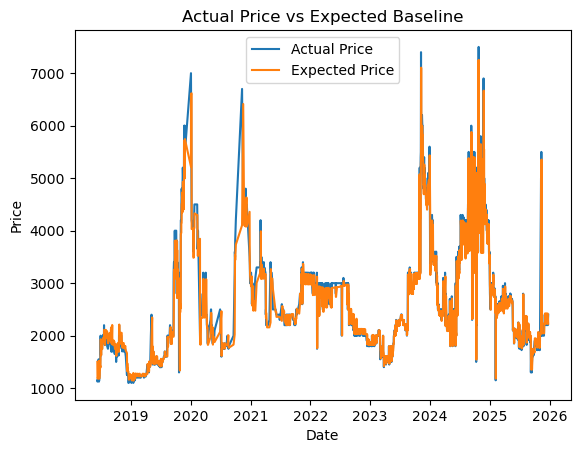

In [14]:
plt.figure()
plt.plot(v2["date"], v2["actual_price"], label="Actual Price")
plt.plot(v2["date"], v2["expected_price"], label="Expected Price")
plt.legend()
plt.title("Actual Price vs Expected Baseline")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


## Core Abnormality Signals

We derive interpretable signals from V1 residuals.

Signals:
- abs_z       → how surprising the price is
- residual_sign → upward vs downward stress
- vol_z       → volatility relative to recent normal

These are inputs, not decisions.

In [13]:
# Absolute deviation magnitude
v2["abs_z"] = v2["residual_z"].abs()

# Direction of deviation (+1 upward, -1 downward)
v2["residual_sign"] = np.sign(v2["residual"])

# Volatility normalized by recent median
v2["vol_z"] = (
    v2["rolling_vol"] /
    v2["rolling_vol"].rolling(90, min_periods=30).median()
)

# Quick sanity check
v2[["abs_z", "vol_z"]].describe()

,abs_z,vol_z
count,2887.000000,2858.000000
mean,1.005148,1.270150
std,3.811196,1.771309
min,0.000227,0.209056
25%,0.163484,0.734434
50%,0.389541,0.955333
75%,0.773770,1.218097
max,47.046127,19.376682


## Visualizing Abnormality Signals

These plots help confirm:
- Most days are normal
- Shocks exist as long-tail events


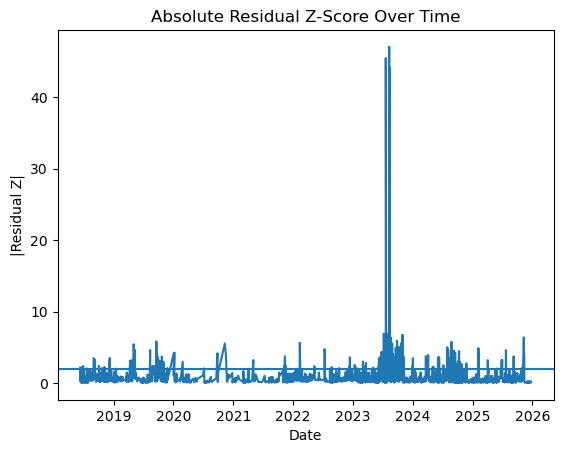

In [15]:
plt.figure()
plt.plot(v2["date"], v2["abs_z"])
plt.axhline(2.0)
plt.title("Absolute Residual Z-Score Over Time")
plt.xlabel("Date")
plt.ylabel("|Residual Z|")
plt.show()


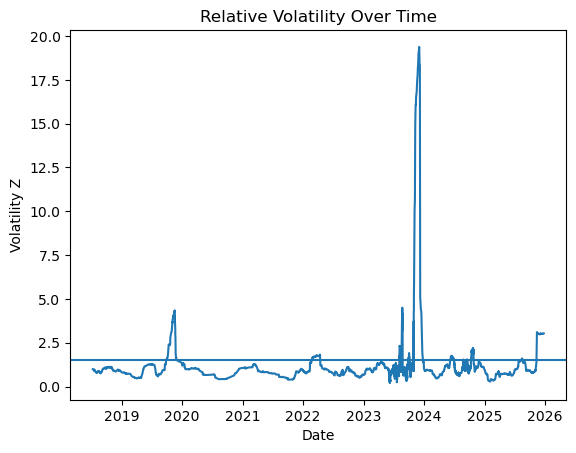

In [16]:
plt.figure()
plt.plot(v2["date"], v2["vol_z"])
plt.axhline(1.5)
plt.title("Relative Volatility Over Time")
plt.xlabel("Date")
plt.ylabel("Volatility Z")
plt.show()


## Abnormal Day Detection

A day is considered abnormal if **either**:
- Price deviation is unusually large, OR
- Volatility is unusually high

This is intentionally conservative.


In [17]:
Z_THRESHOLD = 2.0
VOL_THRESHOLD = 1.5

v2["abnormal_day"] = (
    (v2["abs_z"] >= Z_THRESHOLD) |
    (v2["vol_z"] >= VOL_THRESHOLD)
).astype(int)

v2["abnormal_day"].value_counts(normalize=True) * 100


abnormal_day
0    80.117769
1    19.882231
Name: proportion, dtype: float64

## Abnormal Days Highlighted

Red spikes indicate days flagged as abnormal.


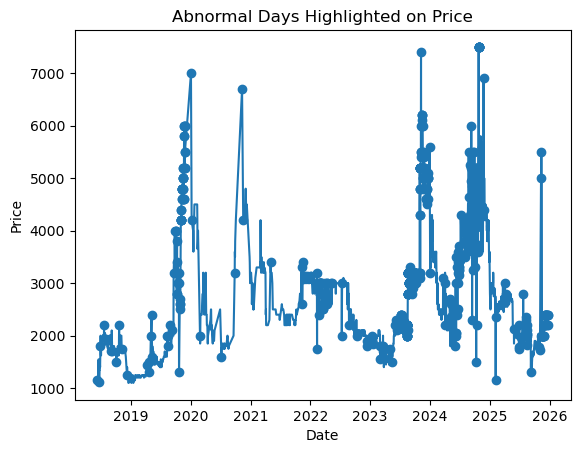

In [19]:
plt.figure()
plt.plot(v2["date"], v2["actual_price"])
plt.scatter(
    v2.loc[v2["abnormal_day"] == 1, "date"],
    v2.loc[v2["abnormal_day"] == 1, "actual_price"]
)
plt.title("Abnormal Days Highlighted on Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


## Persistence Logic

Regimes require persistence.
Single-day spikes do not define regimes.


In [21]:
v2["abnormal_3d"] = (
    v2["abnormal_day"]
    .rolling(3, min_periods=1)
    .sum()
)

v2["abnormal_7d"] = (
    v2["abnormal_day"]
    .rolling(7, min_periods=1)
    .sum()
)


## Regime Classification

Rules:
- Shock: sustained abnormality
- High volatility: short-term stress
- Normal: otherwise


In [22]:
def classify_regime(row):
    if row["abnormal_7d"] >= 4:
        return "shock"
    elif row["abnormal_3d"] >= 2:
        return "high_volatility"
    else:
        return "normal"

v2["regime"] = v2.apply(classify_regime, axis=1)


## Regime Distribution

This shows how often each regime occurs.


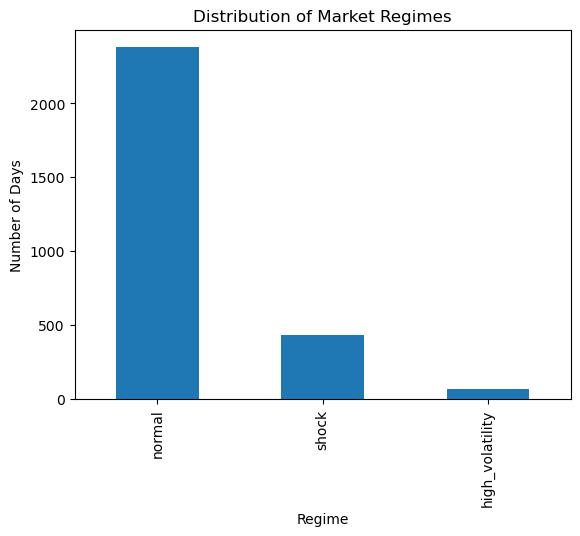

In [23]:
v2["regime"].value_counts().plot(kind="bar")
plt.title("Distribution of Market Regimes")
plt.xlabel("Regime")
plt.ylabel("Number of Days")
plt.show()


## Regime Timeline

Visual confirmation of regime clustering and duration.


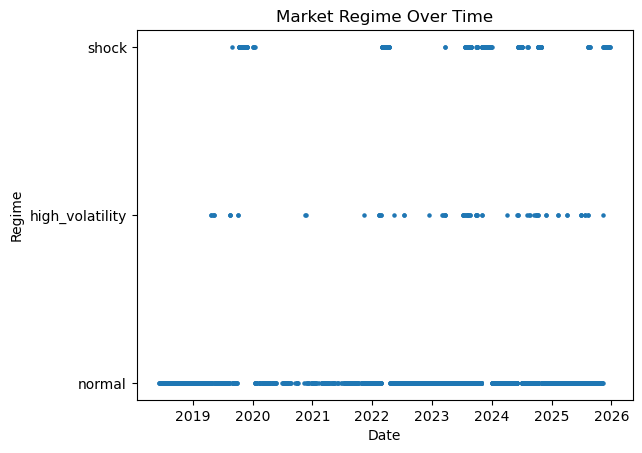

In [24]:
plt.figure()
plt.scatter(v2["date"], v2["regime"], s=5)
plt.title("Market Regime Over Time")
plt.xlabel("Date")
plt.ylabel("Regime")
plt.show()


## Regime Episodes

Continuous regime windows are required for causal analysis.


In [25]:
v2["regime_change"] = (v2["regime"] != v2["regime"].shift()).astype(int)
v2["regime_id"] = v2["regime_change"].cumsum()

v2[["date", "regime", "regime_id"]].head(10)


,date,regime,regime_id
0,2018-06-10,normal,1
1,2018-06-11,normal,1
2,2018-06-12,normal,1
3,2018-06-13,normal,1
4,2018-06-14,normal,1
5,2018-06-16,normal,1
6,2018-06-17,normal,1
7,2018-06-18,normal,1
8,2018-06-19,normal,1
9,2018-06-20,normal,1


## Summary

This notebook:
- Detects abnormal market behavior
- Classifies regimes using transparent rules
- Produces regime episodes for downstream use

Next:
**V2 — Causal Evidence Overlay**
